In [1]:
import os
import cv2
import collections
import time
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
import configparser
import argparse
import wandb

# Catalyst is amazing.
from catalyst.data import Augmentor
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
from catalyst.dl.runner import SupervisedRunner
# from catalyst.dl.runner import SupervisedWandbRunner as SupervisedRunner
from catalyst.contrib.models.segmentation import Unet
from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback

# PyTorch made my work much much easier.
import segmentation_models_pytorch as smp
from dataloader import SegmentationDataset, SegmentationDatasetTest
from augmentations import get_training_augmentation, get_validation_augmentation, get_preprocessing

from utils import *
import pickle

In [2]:
def get_ids(train_ids_file='../train_ids.pkl', valid_ids_file='../valid_ids.pkl'):
    with open(train_ids_file, 'rb') as handle:
        train_ids = pickle.load(handle)

    with open(valid_ids_file, 'rb') as handle:
        valid_ids = pickle.load(handle)

    return train_ids, valid_ids

_, valid_ids = get_ids()


# FIX LOADERS

def get_loaders(bs=32, num_workers=4, preprocessing_fn=None):
        train_ids, valid_ids = get_ids()
        train_dataset = SegmentationDataset(ids=train_ids,
                    transforms=get_training_augmentation(),
                    preprocessing=get_preprocessing(preprocessing_fn),
                    img_db="../input/train_images_525/train_images_525",
                    mask_db="../input/mask")
        valid_dataset = SegmentationDataset(ids=valid_ids,
                    transforms=get_validation_augmentation(),
                    preprocessing=get_preprocessing(preprocessing_fn),
                    img_db="../input/train_images_525/train_images_525",
                    mask_db="../input/mask")

        train_loader = DataLoader(train_dataset, batch_size=bs,
            shuffle=True, num_workers=num_workers)
        valid_loader = DataLoader(valid_dataset, batch_size=bs,
            shuffle=False, num_workers=num_workers)

        loaders = {
            "train": train_loader,
            "valid": valid_loader
        }
        return loaders
    
bs = 8    
num_workers = 0
encoder = 'efficientnet-b2'
model, preprocessing_fn = get_model(encoder)
# loaders = get_loaders(bs, num_workers, preprocessing_fn)

LIMIT = 20
valid_dataset = SegmentationDataset(ids=valid_ids[:LIMIT],
                    transforms=get_validation_augmentation(),
                    preprocessing=get_preprocessing(preprocessing_fn),
                    img_db="../input/train_images_525/train_images_525",
                    mask_db="../input/mask")

valid_loader = DataLoader(valid_dataset, batch_size=bs,
            shuffle=False, num_workers=num_workers)

Training on unet architecture with efficientnet-b2 encoder


/home/timetraveller/.local/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:2567: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().



In [3]:
len(valid_dataset)

20

# Load the model

In [5]:
runner = SupervisedRunner()
encoded_pixels = []
loaders = {"infer": valid_loader}
runner.infer(
    model=model,
    loaders=loaders,
    callbacks=[
        CheckpointCallback(
            resume=f"../models/best.pth"),
        InferCallback()
    ],
)

/home/timetraveller/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/timetraveller/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/timetraveller/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/timetraveller/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version

=> loading checkpoint ../models/best.pth
loaded checkpoint ../models/best.pth (epoch 10)
Top best models:



In [6]:
# import tqdm

# valid_masks = []
# probabilities = np.zeros((2220, 350, 525))
# for i, (batch, output) in enumerate(tqdm.tqdm(zip(
#         valid_dataset, runner.callbacks[0].predictions["logits"]))):
#     image, mask = batch
#     for m in mask:
#         if m.shape != (350, 525):
#             m = cv2.resize(m, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
#         valid_masks.append(m)

#     for j, probability in enumerate(output):
#         if probability.shape != (350, 525):
#             probability = cv2.resize(probability, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
#         probabilities[i * 4 + j, :, :] = probability

In [22]:
def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)
    
    if img1.sum() + img2.sum() == 0:
        print("ok...")
        return 1

    intersection = np.logical_and(img1, img2)

    return 2. * intersection.sum() / (img1.sum() + img2.sum())


def post_process(probability, threshold, min_size, threshold_type='percentile'):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    # don't remember where I saw it
    if threshold_type == 'mean':
        threshold = np.mean(probability)
    elif threshold_type == 'percentile':    
        threshold = np.percentile(probability, threshold)    
        
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

sigmoid = lambda x: 1 / (1 + np.exp(-x))

In [ ]:
??cv2.threshold

# Visualize

In [23]:
def visualize_with_raw(image, mask, original_image=None, original_mask=None, raw_image=None, raw_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}

    f, ax = plt.subplots(3, 5, figsize=(24, 12))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(original_mask[:, :, i])
        ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)


    ax[1, 0].imshow(raw_image)
    ax[1, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(raw_mask[:, :, i])
        ax[1, i + 1].set_title(f'Raw predicted mask {class_dict[i]}', fontsize=fontsize)
        
    ax[2, 0].imshow(image)
    ax[2, 0].set_title('Transformed image', fontsize=fontsize)


    for i in range(4):
        ax[2, i + 1].imshow(mask[:, :, i])
        ax[2, i + 1].set_title(f'Predicted mask with processing {class_dict[i]}', fontsize=fontsize)

W1106 02:26:52.105220 140308780074816 image.py:664] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1106 02:26:52.112505 140308780074816 image.py:664] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1106 02:26:52.120974 140308780074816 image.py:664] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1106 02:26:52.248366 140308780074816 image.py:664] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1106 02:26:52.255652 140308780074816 image.py:664] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1106 02:26:52.262645 140308780074816 image.py:664] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1106 02:26:52.397592 140308

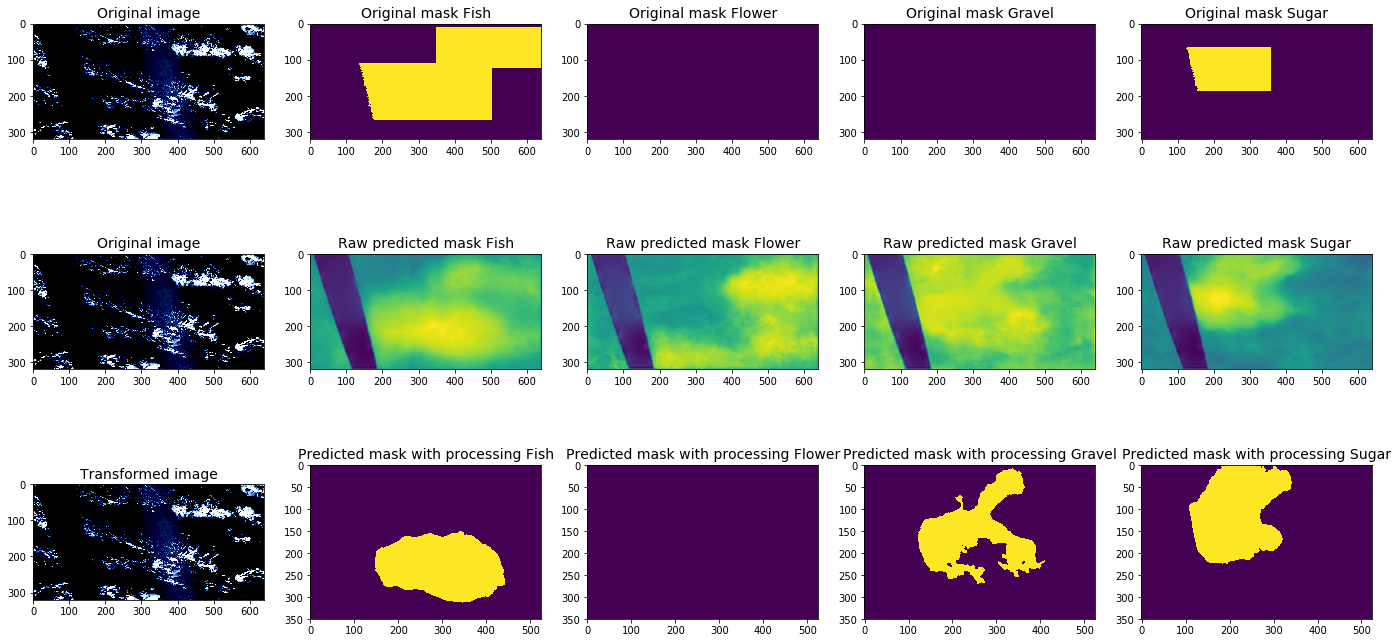

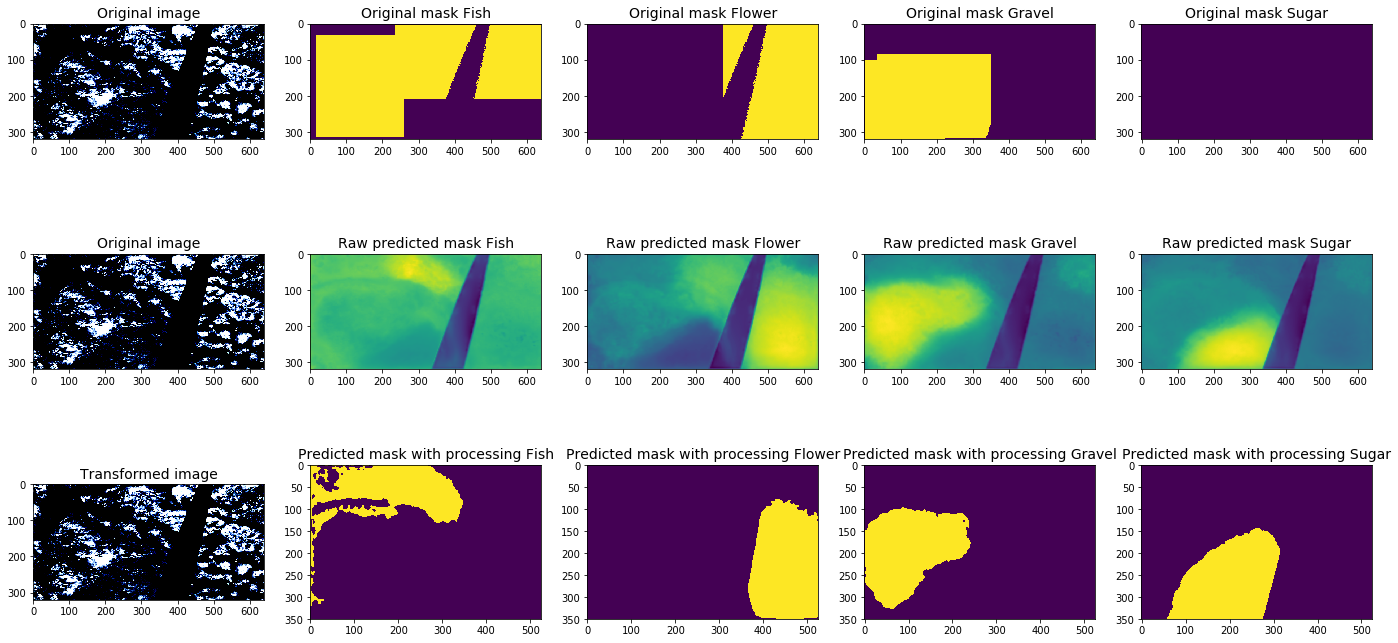

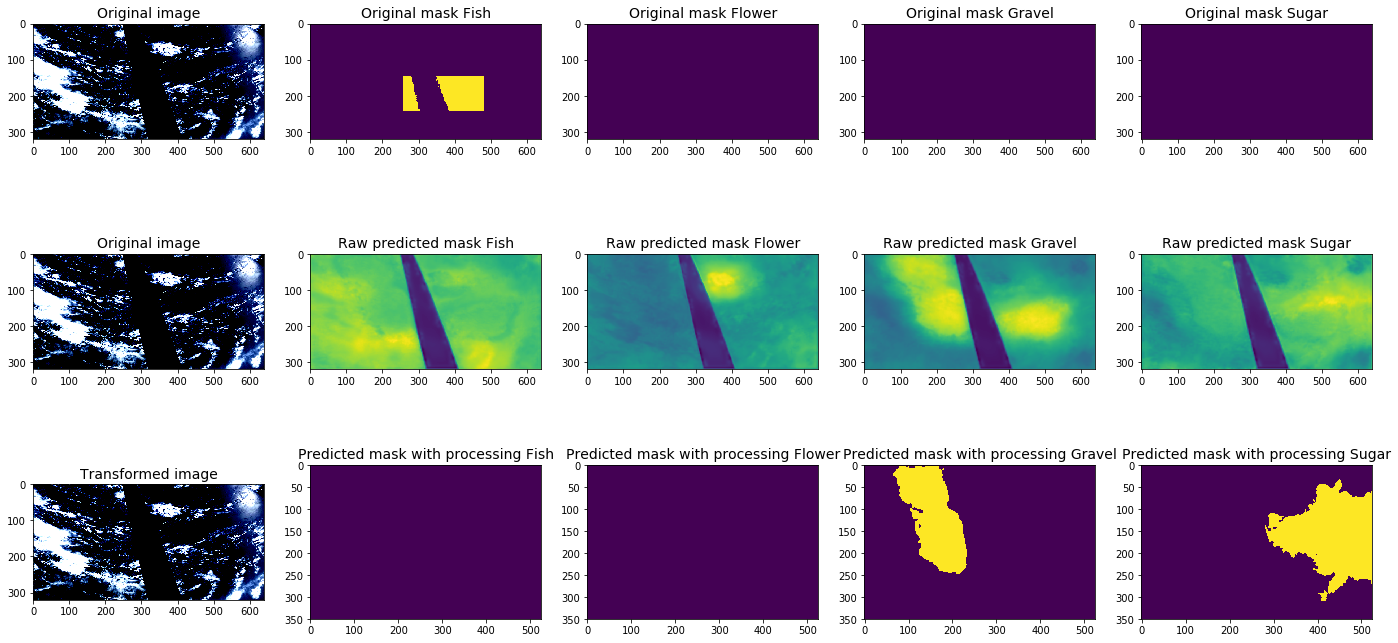

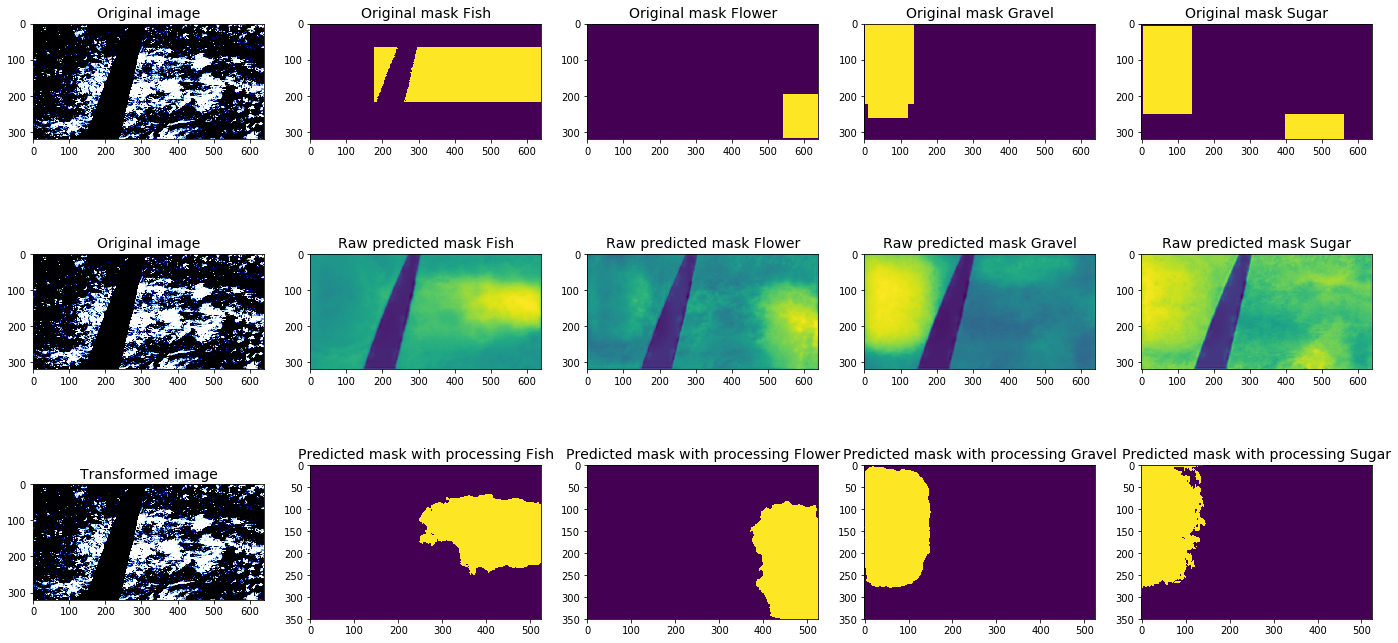

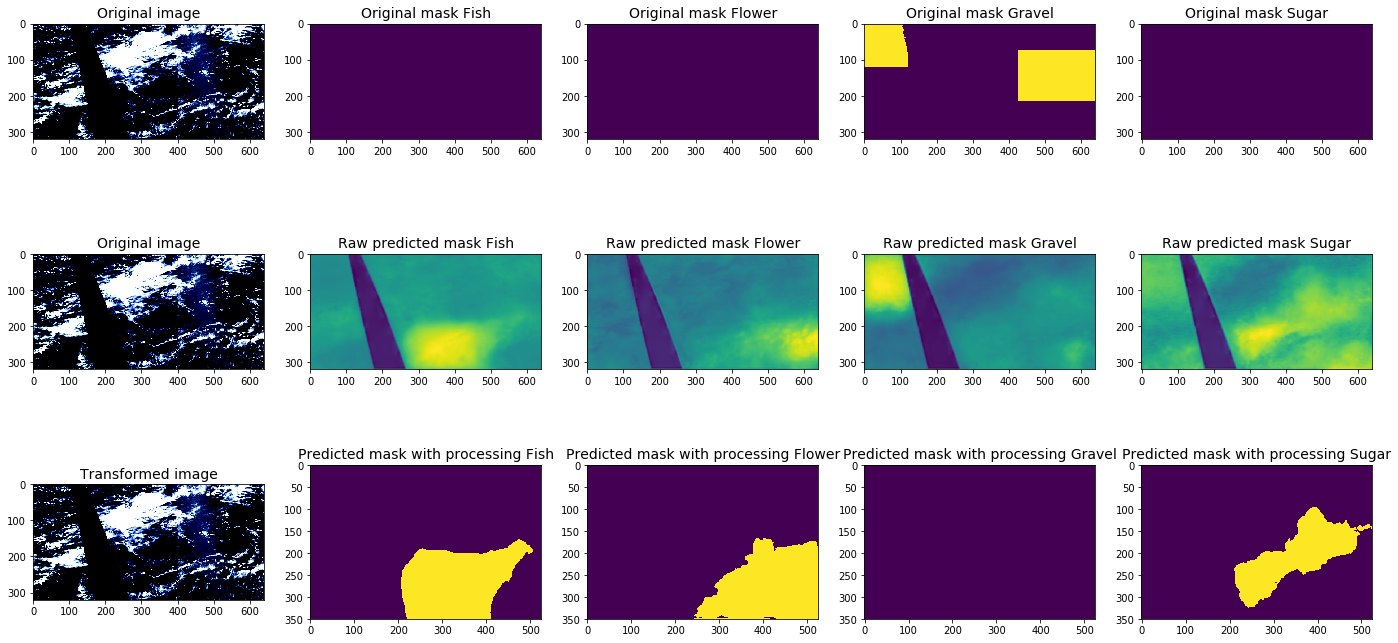

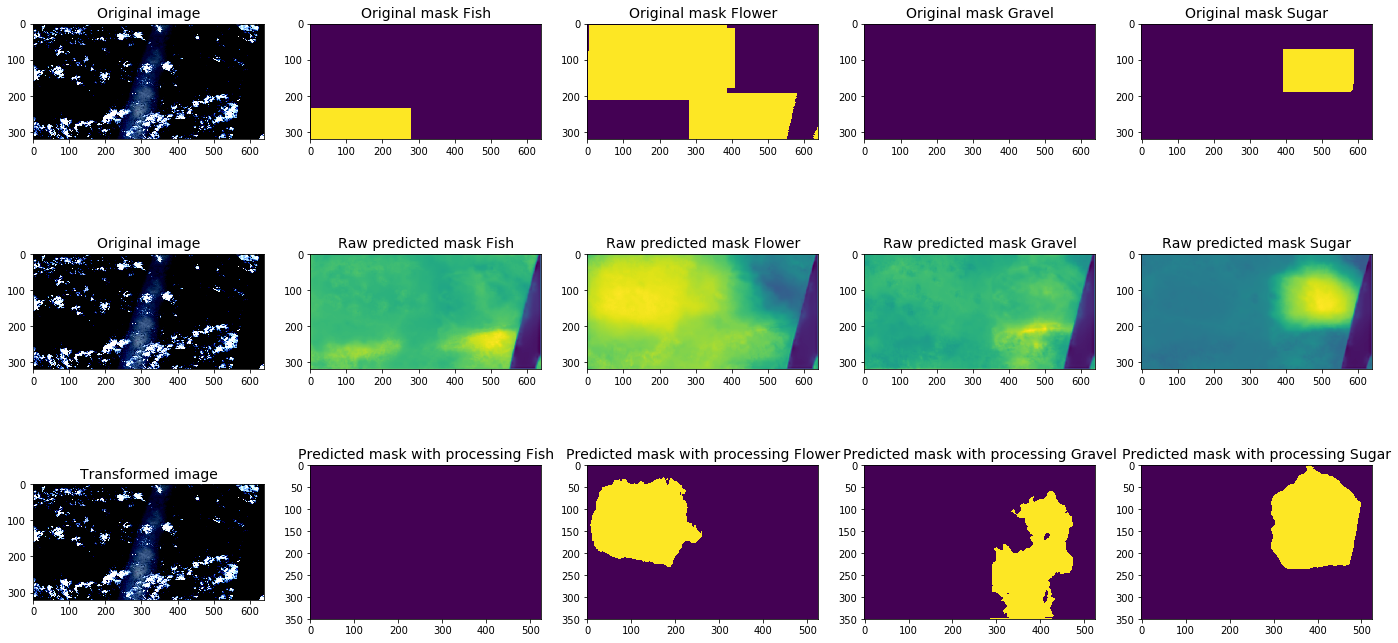

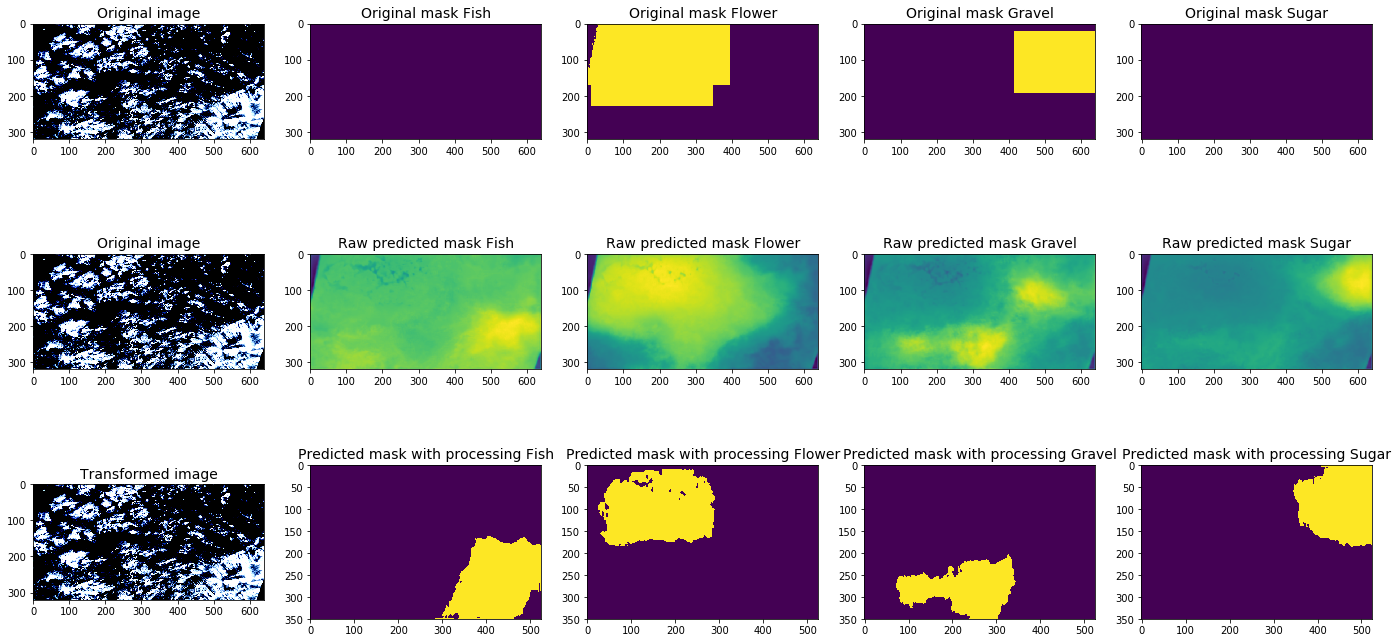

In [29]:
threshold, min_size = 80, 22000
for i, (input, output) in enumerate(zip(
        valid_dataset, runner.callbacks[0].predictions["logits"])):
    image, mask = input
        
    image_vis = image.transpose(1, 2, 0)
    mask = mask.astype('uint8').transpose(1, 2, 0)
    pr_mask = np.zeros((350, 525, 4))
    for j in range(4):
        probability = cv2.resize(output.transpose(1, 2, 0)[:, :, j], dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
        pr_mask[:, :, j], _ = post_process(sigmoid(probability), threshold, min_size)
    #pr_mask = (sigmoid(output) > best_threshold).astype('uint8').transpose(1, 2, 0)
    
        
    visualize_with_raw(image=image_vis, mask=pr_mask, original_image=image_vis, original_mask=mask, raw_image=image_vis, raw_mask=output.transpose(1, 2, 0))
    
    if i >= 6:
        break

-2.273978877067568